In [37]:
import wandb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def minmax_normalize(history, variant: str = 'vanilla'):
    assert variant in ['vanilla', 'last', 'rolling']
    if variant == 'vanilla':
        return (history - history.min(axis=0)) / (history.max(axis=0) - history.min(axis=0))
    elif variant == 'last':
        return (history - history.min(axis=0)) / (history.iloc[-1] - history.min(axis=0))
    elif variant == 'rolling':
        rolling_min = history.expanding().min()
        rolling_max = history.expanding().max()
        return (history - rolling_min) / (rolling_max - rolling_min)

def moving_average(data, window_size):
    return data.rolling(window=window_size, min_periods=1).mean()


def get_history(run_path: str):
    api = wandb.Api()

    run = api.run(run_path)

    history = run.history()
    history.head()

    phase = 'val/'

    spearman_cols = [col for col in history.columns if phase in col and '_spearman' in col]
    mae_cols = [col for col in history.columns if phase in col and '_mae' in col]
    roc_auc_cols = [col for col in history.columns if phase in col and '_roc-auc' in col]
    pr_auc_cols = [col for col in history.columns if phase in col and '_pr-auc' in col]

    spearman_history = history[spearman_cols].dropna()
    mae_history = history[mae_cols].dropna()
    roc_auc_history = history[roc_auc_cols].dropna()
    pr_auc_history = history[pr_auc_cols].dropna()
    return spearman_history, mae_history, roc_auc_history, pr_auc_history


def update_weighting_dict(sweep_id: str, weighting_dict: dict, weighting: str, summary_keys: list):
    api = wandb.Api()
    runs = api.runs("BorgwardtLab/libmtl_tdc", filters={"sweep": sweep_id})

    for run in runs:
        run_weighting = run.config.get("weighting")

        if run_weighting == weighting:

            for var_name in summary_keys:
                var_value = run.summary.get(var_name, None)
                if var_value is None:
                    continue
            
                if weighting not in weighting_dict:
                    weighting_dict[weighting] = {}

                if var_name not in weighting_dict[weighting]:
                    weighting_dict[weighting][var_name] = []

                weighting_dict[weighting][var_name].append(var_value)

    return weighting_dict

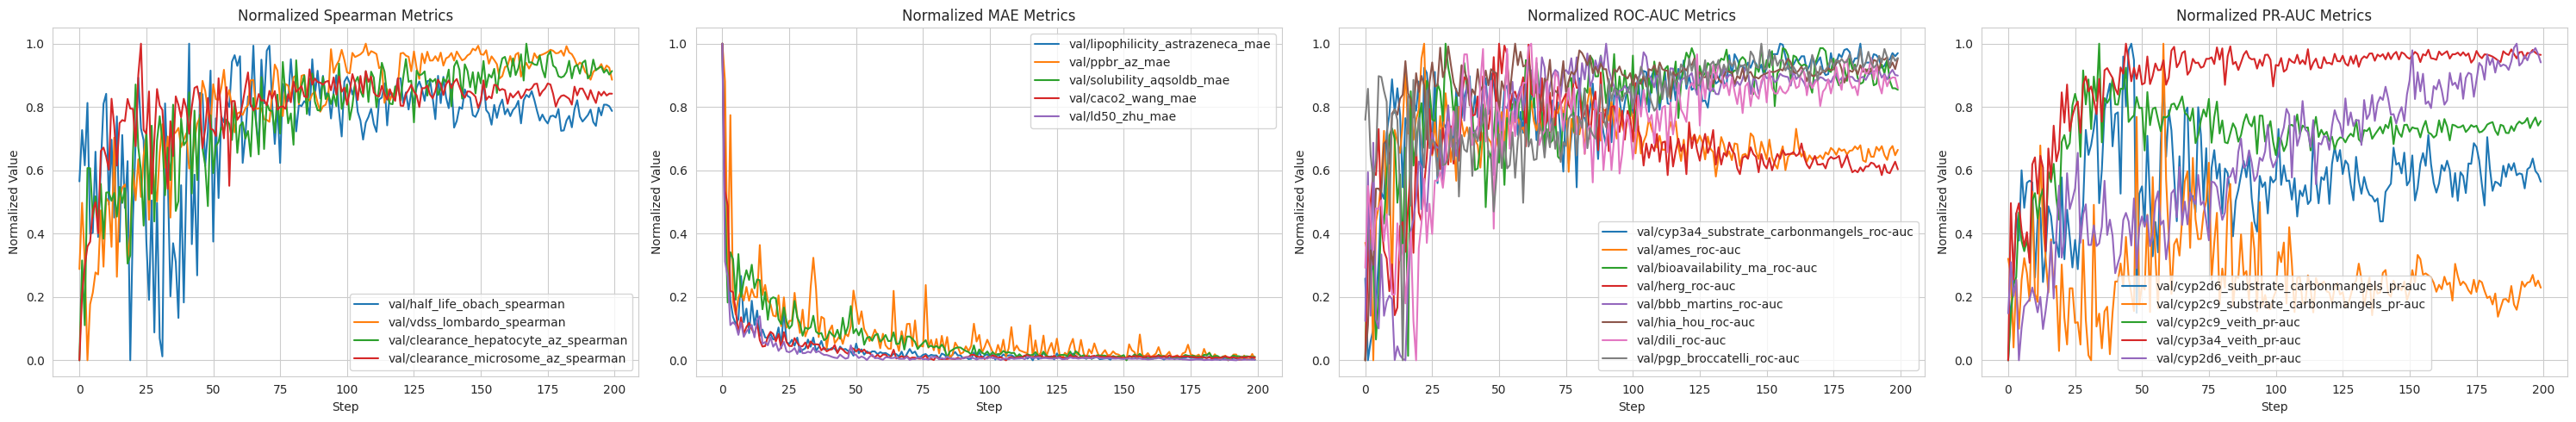

In [50]:
run_path = "BorgwardtLab/libmtl_tdc/runs/q7rcs9j4" # DB_MTL
# run_path = "BorgwardtLab/libmtl_tdc/runs/8t48r65y" # EW
# run_path = "BorgwardtLab/libmtl_tdc/runs/l08io039" # CAGrad

spearman_history, mae_history, roc_auc_history, pr_auc_history = get_history(run_path)

spearman_history_normed = minmax_normalize(spearman_history)
mae_history_normed = minmax_normalize(mae_history)
roc_auc_history_normed = minmax_normalize(roc_auc_history)
pr_auc_history_normed = minmax_normalize(pr_auc_history)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 5))

if not spearman_history_normed.empty:
    spearman_history_normed.plot(ax=ax1)
    ax1.set_title('Normalized Spearman Metrics')
    ax1.set_xlabel('Step')
    ax1.set_ylabel('Normalized Value')
    ax1.legend(loc='best')

if not mae_history_normed.empty:
    mae_history_normed.plot(ax=ax2)
    ax2.set_title('Normalized MAE Metrics')
    ax2.set_xlabel('Step') 
    ax2.set_ylabel('Normalized Value')
    ax2.legend(loc='best')

if not roc_auc_history_normed.empty:
    roc_auc_history_normed.plot(ax=ax3)
    ax3.set_title('Normalized ROC-AUC Metrics')
    ax3.set_xlabel('Step')
    ax3.set_ylabel('Normalized Value')
    ax3.legend(loc='best')

if not pr_auc_history_normed.empty:
    pr_auc_history_normed.plot(ax=ax4)
    ax4.set_title('Normalized PR-AUC Metrics')
    ax4.set_xlabel('Step')
    ax4.set_ylabel('Normalized Value')
    ax4.legend(loc='best')

plt.tight_layout()
plt.show()


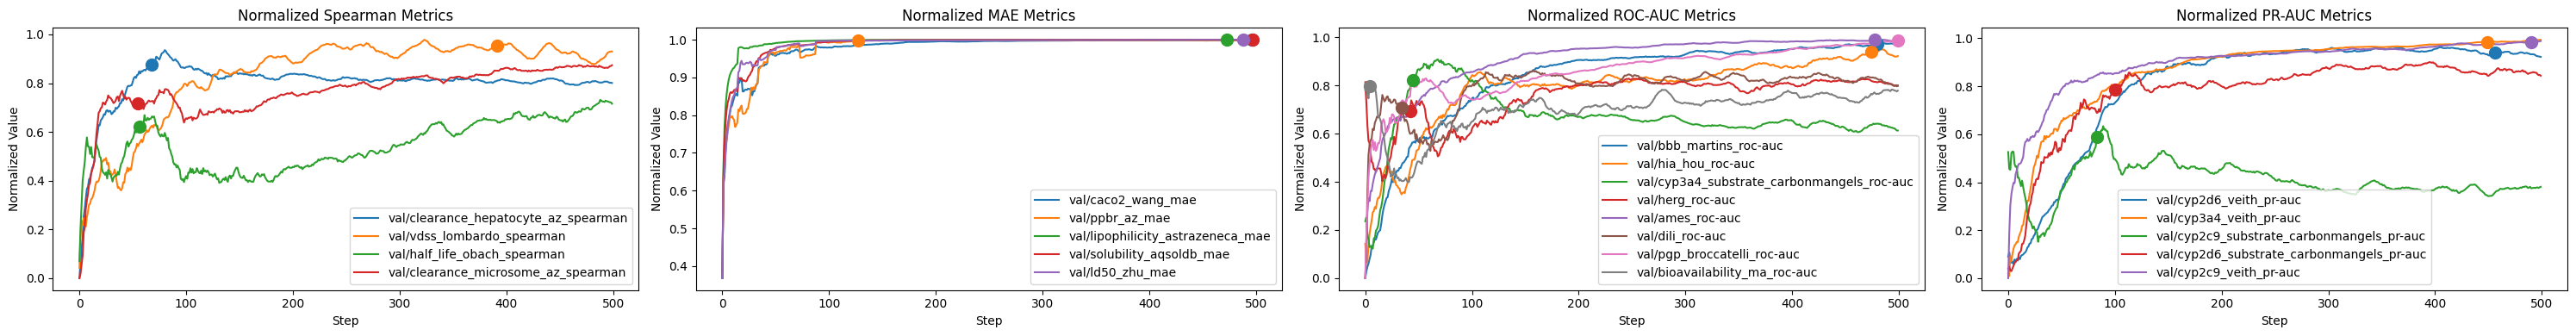

In [36]:
run_path = "BorgwardtLab/libmtl_tdc/yyj0y6jj" # EW
# run_path = "BorgwardtLab/libmtl_tdc/6cxf84eu" # FairGrad
# run_path = "BorgwardtLab/libmtl_tdc/64mdvbcs" # DB_MTL
spearman_history, mae_history, roc_auc_history, pr_auc_history = get_history(run_path)

smoothing_factor = 15  
normalization_variant = 'vanilla'

spearman_normed = minmax_normalize(spearman_history, normalization_variant)
mae_normed = minmax_normalize(mae_history, normalization_variant)
roc_auc_normed = minmax_normalize(roc_auc_history, normalization_variant)
pr_auc_normed = minmax_normalize(pr_auc_history, normalization_variant)

mae_normed_exp = np.exp(-mae_normed**2)

spearman_normed_smoothed = moving_average(spearman_normed, smoothing_factor)
mae_normed_smoothed = moving_average(mae_normed_exp, smoothing_factor)
roc_auc_normed_smoothed = moving_average(roc_auc_normed, smoothing_factor)
pr_auc_normed_smoothed = moving_average(pr_auc_normed, smoothing_factor)

fig, axes = plt.subplots(1, 4, figsize=(30, 4))
ax1, ax2, ax3, ax4 = axes.flatten()

spearman_normed_smoothed.plot(ax=ax1)
for i, col in enumerate(spearman_normed_smoothed.columns):
    if not spearman_normed_smoothed[col].isnull().all(): 
        max_idx = spearman_normed[col].idxmax()
        max_val = spearman_normed_smoothed[col].iloc[max_idx]
        if i < len(ax1.get_lines()): 
                line_color = ax1.get_lines()[i].get_color()
                ax1.scatter(max_idx, max_val, color=line_color, s=100, zorder=5) 
ax1.set_title('Normalized Spearman Metrics')
ax1.set_xlabel('Step')
ax1.set_ylabel('Normalized Value')
ax1.legend(loc='best')

mae_normed_smoothed.plot(ax=ax2)
for i, col in enumerate(mae_normed_smoothed.columns):
    if not mae_normed_smoothed[col].isnull().all():
        max_idx = mae_normed_exp[col].idxmax() 
        max_val = mae_normed_smoothed[col].iloc[max_idx]
        if i < len(ax2.get_lines()):
            line_color = ax2.get_lines()[i].get_color()
            ax2.scatter(max_idx, max_val, color=line_color, s=100, zorder=5)
ax2.set_title('Normalized MAE Metrics')
ax2.set_xlabel('Step')
ax2.set_ylabel('Normalized Value')
ax2.legend(loc='best')

roc_auc_normed_smoothed.plot(ax=ax3)
for i, col in enumerate(roc_auc_normed_smoothed.columns):
    if not roc_auc_normed_smoothed[col].isnull().all():
        max_idx = roc_auc_normed[col].idxmax()
        max_val = roc_auc_normed_smoothed[col].iloc[max_idx]
        if i < len(ax3.get_lines()):
            line_color = ax3.get_lines()[i].get_color()
            ax3.scatter(max_idx, max_val, color=line_color, s=100, zorder=5)
ax3.set_title('Normalized ROC-AUC Metrics')
ax3.set_xlabel('Step')
ax3.set_ylabel('Normalized Value')
ax3.legend(loc='best')


pr_auc_normed_smoothed.plot(ax=ax4)
for i, col in enumerate(pr_auc_normed_smoothed.columns):
    if not pr_auc_normed_smoothed[col].isnull().all():
        max_idx = pr_auc_normed[col].idxmax()
        max_val = pr_auc_normed_smoothed[col].iloc[max_idx]
        if i < len(ax4.get_lines()):
            line_color = ax4.get_lines()[i].get_color()
            ax4.scatter(max_idx, max_val, color=line_color, s=100, zorder=5)
ax4.set_title('Normalized PR-AUC Metrics')
ax4.set_xlabel('Step')
ax4.set_ylabel('Normalized Value')
ax4.legend(loc='best')

fig.tight_layout()
plt.show()


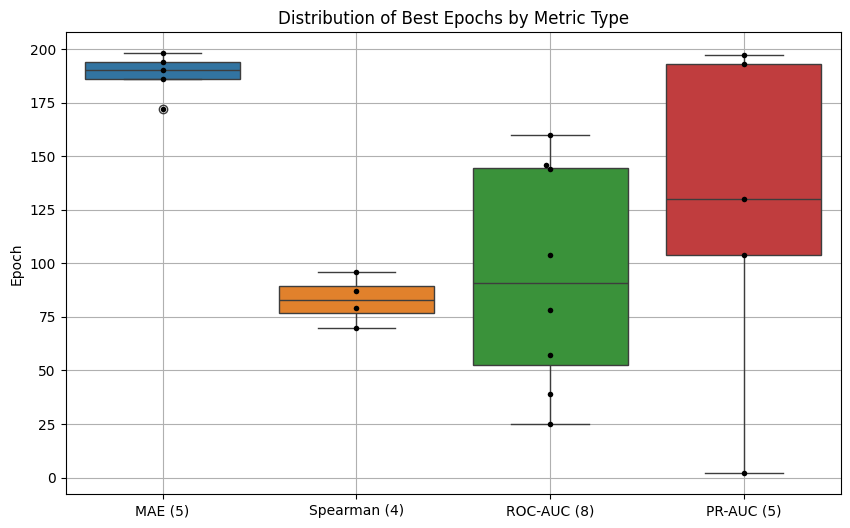

In [24]:
best_epochs = pd.DataFrame({
    f'MAE ({len(mae_history.columns)})': mae_history.apply(lambda x: x.argmin()),
    f'Spearman ({len(spearman_history.columns)})': spearman_history.apply(lambda x: x.argmax()),
    f'ROC-AUC ({len(roc_auc_history.columns)})': roc_auc_history.apply(lambda x: x.argmax()),
    f'PR-AUC ({len(pr_auc_history.columns)})': pr_auc_history.apply(lambda x: x.argmax())
})

plt.figure(figsize=(10, 6))
sns.boxplot(data=best_epochs)
sns.swarmplot(data=best_epochs, color='black', size=4)
plt.title('Distribution of Best Epochs by Metric Type')
plt.ylabel('Epoch')
plt.grid(True)
plt.show()


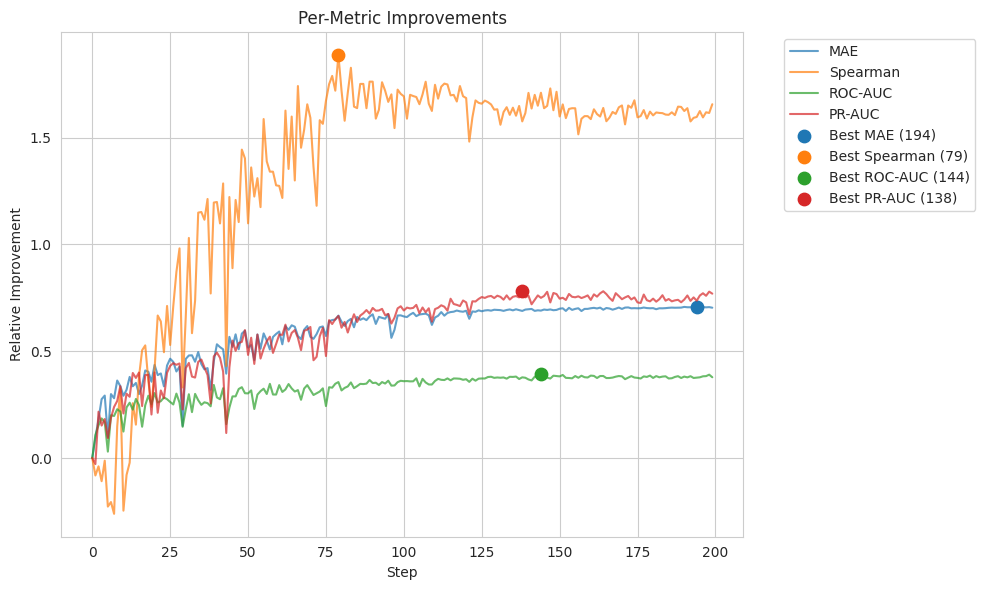

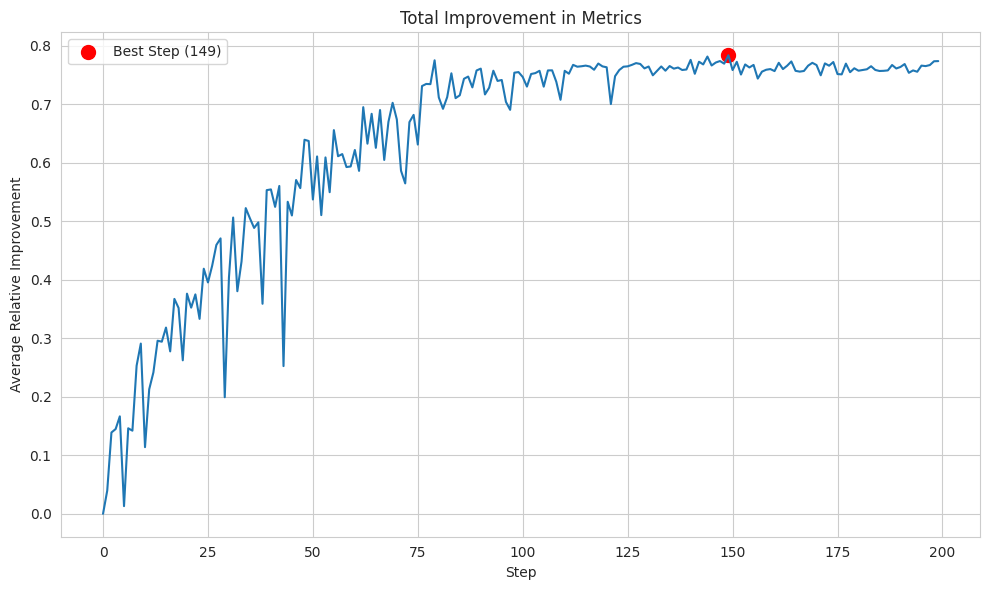


Final total improvement: nan
Best improvement 0.783 at step 149


In [84]:
base_mae = mae_history.iloc[0].to_numpy()
base_spearman = spearman_history.iloc[0].to_numpy()
base_roc = roc_auc_history.iloc[0].to_numpy()
base_pr = pr_auc_history.iloc[0].to_numpy()

mae_improvements = pd.DataFrame((base_mae - mae_history) / base_mae, 
                              index=mae_history.index,
                              columns=mae_history.columns)
spearman_improvements = pd.DataFrame(-1 * (base_spearman - spearman_history) / base_spearman,
                                   index=spearman_history.index, 
                                   columns=spearman_history.columns)
roc_auc_improvements = pd.DataFrame(-1 * (base_roc - roc_auc_history) / base_roc,
                                  index=roc_auc_history.index,
                                  columns=roc_auc_history.columns) 
pr_auc_improvements = pd.DataFrame(-1 * (base_pr - pr_auc_history) / base_pr,
                                 index=pr_auc_history.index,
                                 columns=pr_auc_history.columns)

ranks_improvement = pd.concat([
    mae_improvements.mean(axis=1).rename('MAE'),
    spearman_improvements.mean(axis=1).rename('Spearman'),
    roc_auc_improvements.mean(axis=1).rename('ROC-AUC'), 
    pr_auc_improvements.mean(axis=1).rename('PR-AUC')
], axis=1)

total_improvement = pd.concat([
    mae_improvements,
    spearman_improvements,
    roc_auc_improvements, 
    pr_auc_improvements
], axis=1).mean(axis=1)

plt.figure(figsize=(10, 6))
improvements_melted = ranks_improvement.reset_index().melt('index', var_name='Metric', value_name='Improvement')
g = sns.lineplot(data=improvements_melted, x='index', y='Improvement', hue='Metric', alpha=0.7)

for metric in ranks_improvement.columns:
    best_step = ranks_improvement[metric].idxmax()
    best_value = ranks_improvement[metric][best_step]
    line_color = g.get_lines()[list(ranks_improvement.columns).index(metric)].get_color()
    plt.scatter(best_step, best_value, color=line_color, s=80, label=f'Best {metric} ({best_step})')

plt.title('Per-Metric Improvements')
plt.xlabel('Step')
plt.ylabel('Relative Improvement')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
df = pd.DataFrame({'Step': total_improvement.index, 'Improvement': total_improvement.values})
sns.lineplot(data=df, x='Step', y='Improvement')
best_step = total_improvement.idxmax()
best_value = total_improvement[best_step]
plt.scatter(best_step, best_value, color='red', s=100, label=f'Best Step ({best_step})')

plt.title('Total Improvement in Metrics')
plt.xlabel('Step')
plt.ylabel('Average Relative Improvement')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("\nFinal total improvement:", total_improvement.iloc[-1].round(3))
print(f"Best improvement {best_value:.3f} at step {best_step}")

Max step: 198 (epoch 198), Max value: 0.12182818581101204


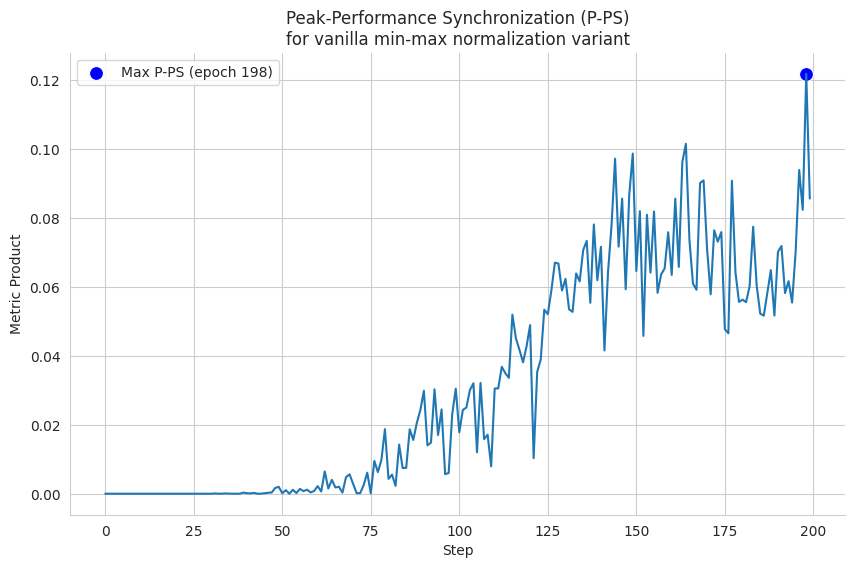

In [43]:
min_max_norm_variant = 'vanilla'
spearman_history_normed = minmax_normalize(spearman_history, min_max_norm_variant)
mae_history_normed      = 1 - minmax_normalize(mae_history, min_max_norm_variant)
roc_auc_history_normed  = minmax_normalize(roc_auc_history, min_max_norm_variant)
pr_auc_history_normed   = minmax_normalize(pr_auc_history, min_max_norm_variant)

all_metrics = np.concatenate([mae_history_normed.values,    
                              spearman_history_normed.values,
                              roc_auc_history_normed.values,
                              pr_auc_history_normed.values], axis=1)

ranks_pps = np.prod(all_metrics, axis=1)

max_step = np.argmax(ranks_pps)
max_value = ranks_pps[max_step]

print(f"Max step: {max_step} (epoch {max_step}), Max value: {max_value}")

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
df = pd.DataFrame({'Step': range(len(ranks_pps)), 'P-PS Score': ranks_pps})
sns.lineplot(data=df, x='Step', y='P-PS Score')
sns.scatterplot(x=[max_step], y=[max_value], color='blue', s=100, label=f'Max P-PS (epoch {max_step})')

sns.despine()
plt.title(f'Peak-Performance Synchronization (P-PS)\nfor {min_max_norm_variant} min-max normalization variant')
plt.xlabel('Step')
plt.ylabel('Metric Product')
plt.legend()
plt.show()

In [26]:

api = wandb.Api()
sweep_id = "t3sqagzr"
runs = api.runs("BorgwardtLab/libmtl_tdc", filters={"sweep": sweep_id})

weighting_dict = {}

for run in runs:
    weighting = run.config.get("weighting")
    val_pps = run.summary.get("val/pps_max")
    val_rank = run.summary.get("test/average_rank")

    if weighting is not None and val_pps is not None:
        if weighting not in weighting_dict:
            weighting_dict[weighting] = {
                "pps": [],
                "rank": []
            }
        weighting_dict[weighting]["pps"].append(val_pps)
        weighting_dict[weighting]["rank"].append(val_rank)
    else:
        if weighting is None:
            print(f"Run {run.id} has no 'weighting' in config.")
        if val_pps is None:
            print(f"Run {run.id} has no 'val/pps_max' in summary.")


Run cvbvurbd has no 'val/pps_max' in summary.
Run l8u2i2f9 has no 'val/pps_max' in summary.
Run yzllru8a has no 'val/pps_max' in summary.


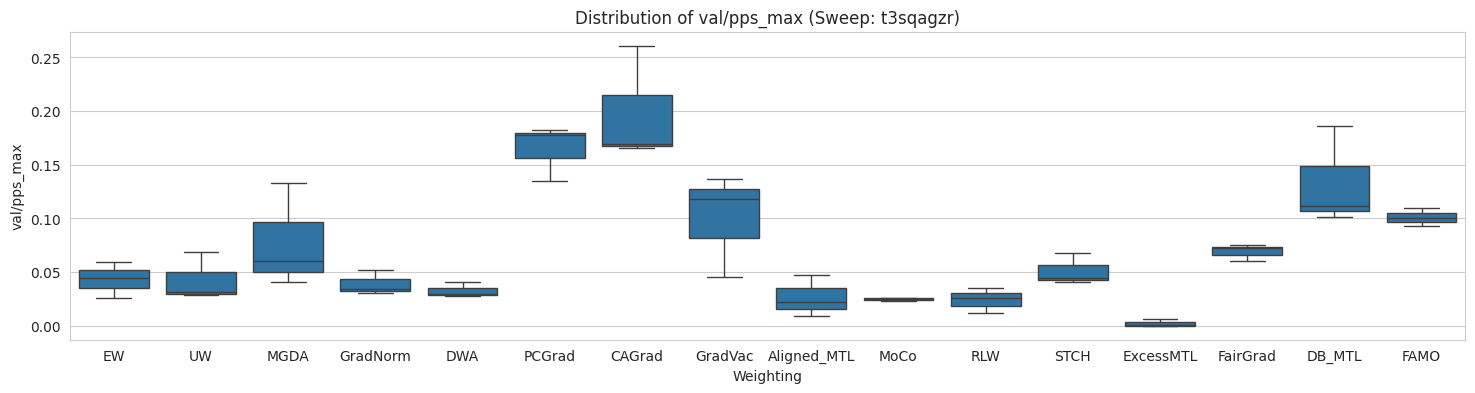

In [17]:
data = [(weighting, val) for weighting, vals in weighting_dict.items() for val in vals["pps"]]
weightings, values = zip(*data)

plt.figure(figsize=(18, 4))

# keep_idx = [i for i, w in enumerate(weightings) if w in ['EW', 'CAGrad', 'DB_MTL']]
# weightings = [weightings[i] for i in keep_idx]
# values = [values[i] for i in keep_idx]

df = pd.DataFrame({'Weighting': weightings, 'Value': values})

sns.boxplot(data=df, x='Weighting', y='Value')
plt.xlabel("Weighting")
plt.ylabel("val/pps_max")
plt.title(f"Distribution of val/pps_max (Sweep: {sweep_id})")
plt.show()

Pearson correlation coefficient: -0.557
P-value: 0.00004


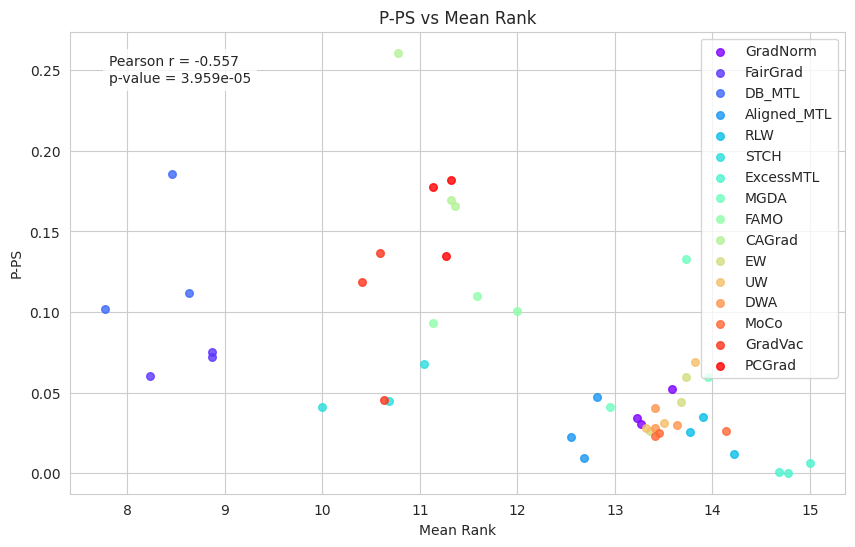

In [39]:
pps_data = [val for _, vals in weighting_dict.items() for val in vals["pps"]]
rank_data = [val for _, vals in weighting_dict.items() for val in vals["rank"]]
weightings = [weighting for weighting, vals in weighting_dict.items() for _ in vals["pps"]]

# Calculate Pearson correlation coefficient
from scipy import stats
correlation, p_value = stats.pearsonr(rank_data, pps_data)
print(f"Pearson correlation coefficient: {correlation:.3f}")
print(f"P-value: {p_value:.5f}")

unique_weightings = list(set(weightings))
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_weightings)))
color_dict = dict(zip(unique_weightings, colors))

plt.figure(figsize=(10, 6))
for weighting in unique_weightings:
    mask = [w == weighting for w in weightings]
    plt.scatter(
        [r for r, m in zip(rank_data, mask) if m],
        [p for p, m in zip(pps_data, mask) if m],
        s=30, alpha=0.8, 
        label=weighting,
        color=color_dict[weighting]
    )
plt.xlabel("Mean Rank")
plt.ylabel("P-PS")
plt.title(f"P-PS vs Mean Rank")
plt.grid(True)
plt.legend()

# Add text box with correlation statistics
text = f'Pearson r = {correlation:.3f}\np-value = {p_value:.3e}'
plt.text(0.05, 0.95, text, transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'),
         verticalalignment='top')

plt.show()


Run 0u8vyeor has no 'test/average_rank_last' in summary.
Run 0u8vyeor has no 'test/average_rank_pps' in summary.
Run 604c4zs5 has no 'test/average_rank_last' in summary.
Run 604c4zs5 has no 'test/average_rank_pps' in summary.
Run 73ia66lf has no 'test/average_rank_last' in summary.
Run 73ia66lf has no 'test/average_rank_pps' in summary.


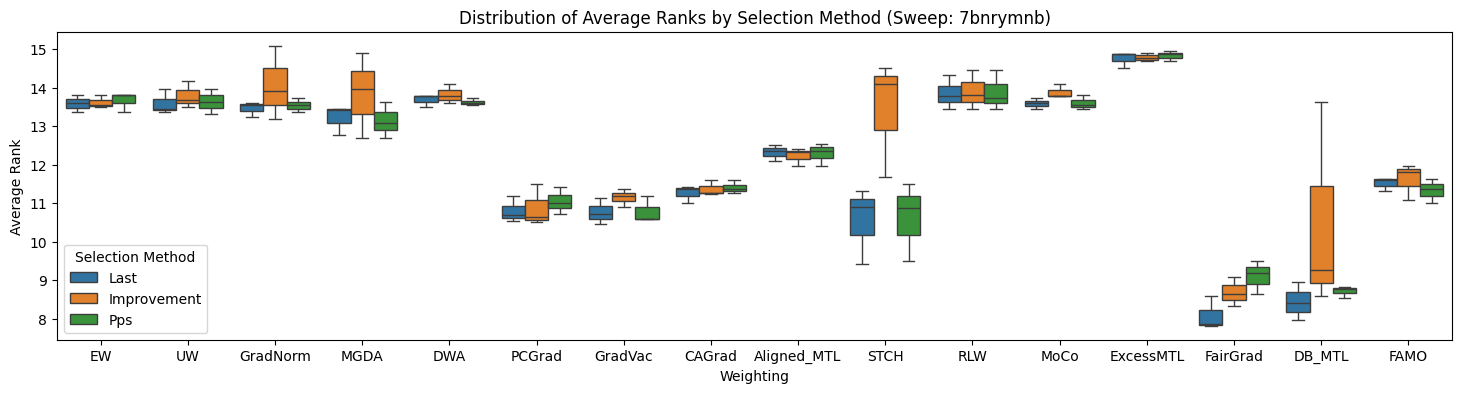

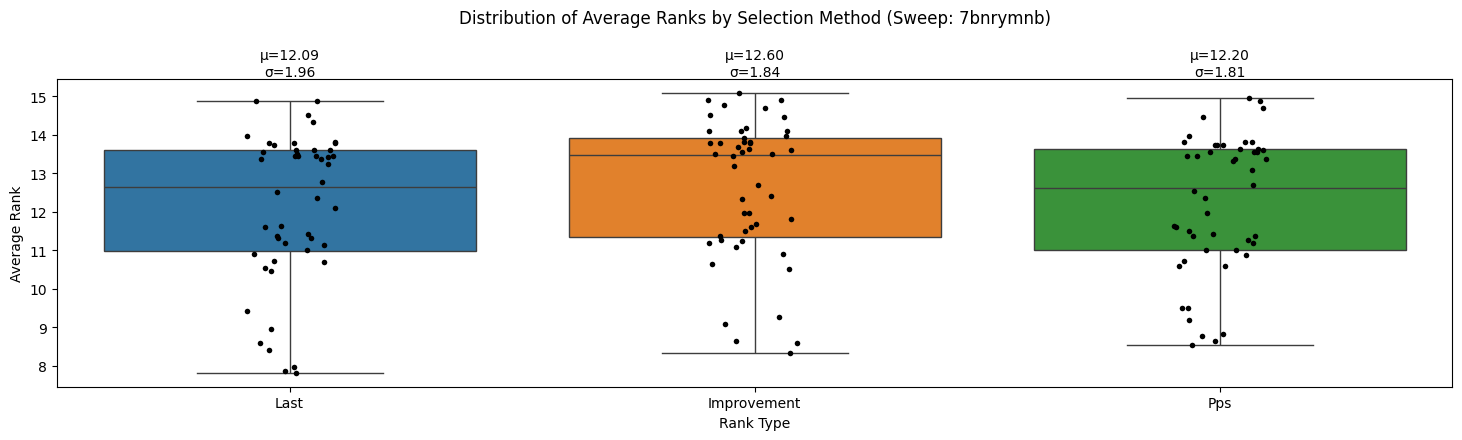

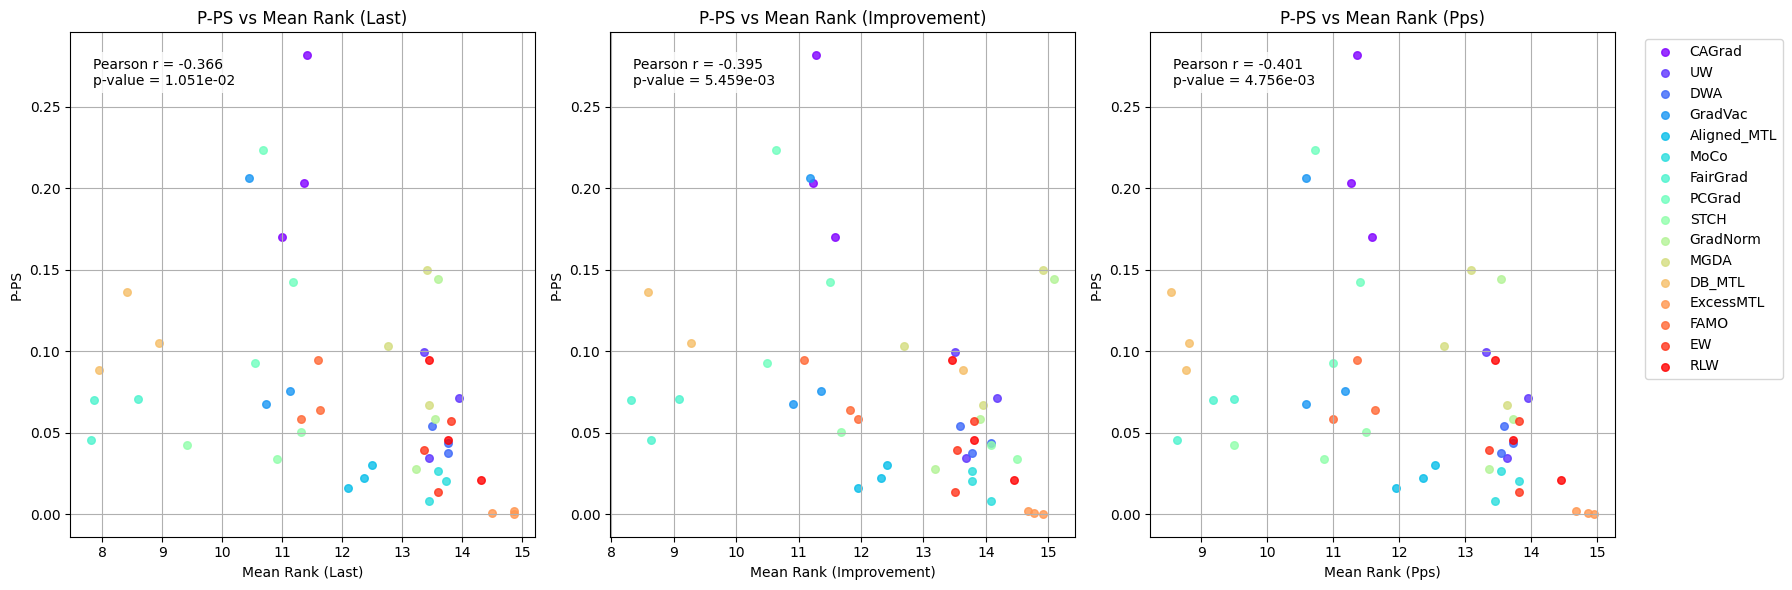

In [30]:
api = wandb.Api()
sweep_id = "7bnrymnb"
runs = api.runs("BorgwardtLab/libmtl_tdc", filters={"sweep": sweep_id})

weighting_dict = {}

for run in runs:
    weighting = run.config.get("weighting")
    rank_last = run.summary.get("test/average_rank_last")
    rank_improvement = run.summary.get("test/average_rank_improvement") 
    rank_pps = run.summary.get("test/average_rank_pps")
    val_pps = run.summary.get("val/pps")


    if (weighting is not None and 
        rank_last is not None and
        rank_improvement is not None and
        rank_pps is not None):
        
        if weighting not in weighting_dict:
            weighting_dict[weighting] = {
                "last": [],
                "improvement": [],
                "pps": [],
                "val_pps": []
            }
        weighting_dict[weighting]["last"].append(rank_last)
        weighting_dict[weighting]["improvement"].append(rank_improvement)
        weighting_dict[weighting]["pps"].append(rank_pps)
        weighting_dict[weighting]["val_pps"].append(val_pps)
    else:
        if weighting is None:
            print(f"Run {run.id} has no 'weighting' in config.")
        if rank_last is None:
            print(f"Run {run.id} has no 'test/average_rank_last' in summary.")
        if rank_improvement is None:
            print(f"Run {run.id} has no 'test/average_rank_improvement' in summary.")
        if rank_pps is None:
            print(f"Run {run.id} has no 'test/average_rank_pps' in summary.")

################################################################################
plot_data = []
for weighting, vals in weighting_dict.items():
    for rank_type in ["last", "improvement", "pps"]:
        for val in vals[rank_type]:
            plot_data.append({
                "Weighting": weighting,
                "Rank Type": rank_type.capitalize(),
                "Value": val
            })
################################################################################
plt.figure(figsize=(18, 4))
df = pd.DataFrame(plot_data)

sns.boxplot(data=df, x='Weighting', y='Value', hue='Rank Type')
plt.ylabel("Average Rank")
plt.title(f"Distribution of Average Ranks by Selection Method (Sweep: {sweep_id})")
plt.legend(title="Selection Method")
plt.show()
################################################################################
plt.figure(figsize=(18, 4))
df = pd.DataFrame(plot_data)
sns.boxplot(data=df, x='Rank Type', y='Value', hue='Rank Type')
sns.stripplot(data=df, x='Rank Type', y='Value', color='black', alpha=1.0, jitter=0.1, size=4)

for i, rank_type in enumerate(df['Rank Type'].unique()):
    vals = df[df['Rank Type'] == rank_type]['Value']
    mean = vals.mean()
    std = vals.std()
    plt.text(i, plt.ylim()[1], f'μ={mean:.2f}\nσ={std:.2f}', 
             horizontalalignment='center', verticalalignment='bottom')

plt.ylabel("Average Rank")
plt.title(f"Distribution of Average Ranks by Selection Method (Sweep: {sweep_id})", pad=40)
plt.show()
################################################################################
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

unique_weightings = list(set(weightings))
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_weightings)))
color_dict = dict(zip(unique_weightings, colors))

pps_data = [val for _, vals in weighting_dict.items() for val in vals["val_pps"]]

for i, rank_type in enumerate(["last", "improvement", "pps"]):
    rank_data = df[df['Rank Type'] == rank_type.capitalize()]['Value'].values
    correlation, p_value = stats.pearsonr(rank_data, pps_data)

    for weighting in unique_weightings:
        mask = [w == weighting for w in weightings]
        axes[i].scatter(
            [r for r, m in zip(rank_data, mask) if m],
            [p for p, m in zip(pps_data, mask) if m],
            s=30, alpha=0.8,
            label=weighting,
            color=color_dict[weighting]
        )
    
    axes[i].set_xlabel(f"Mean Rank ({rank_type.capitalize()})")
    axes[i].set_ylabel("P-PS")
    axes[i].set_title(f"P-PS vs Mean Rank ({rank_type.capitalize()})")
    axes[i].grid(True)
    
    # Add text box with correlation statistics
    text = f'Pearson r = {correlation:.3f}\np-value = {p_value:.3e}'
    axes[i].text(0.05, 0.95, text, transform=axes[i].transAxes,
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'),
            verticalalignment='top')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


{'DB_MTL': {'test/average_rank_last': [7.954545454545454, 8.954545454545455, 8.409090909090908], 'test/average_rank_improvement': [13.636363636363637, 9.272727272727272, 8.590909090909092], 'test/average_rank_pps': [8.772727272727273, 8.818181818181818, 8.545454545454545], 'test/average_rank_independent': [8.318181818181818, 8.409090909090908, 8.5, 8.045454545454545]}}


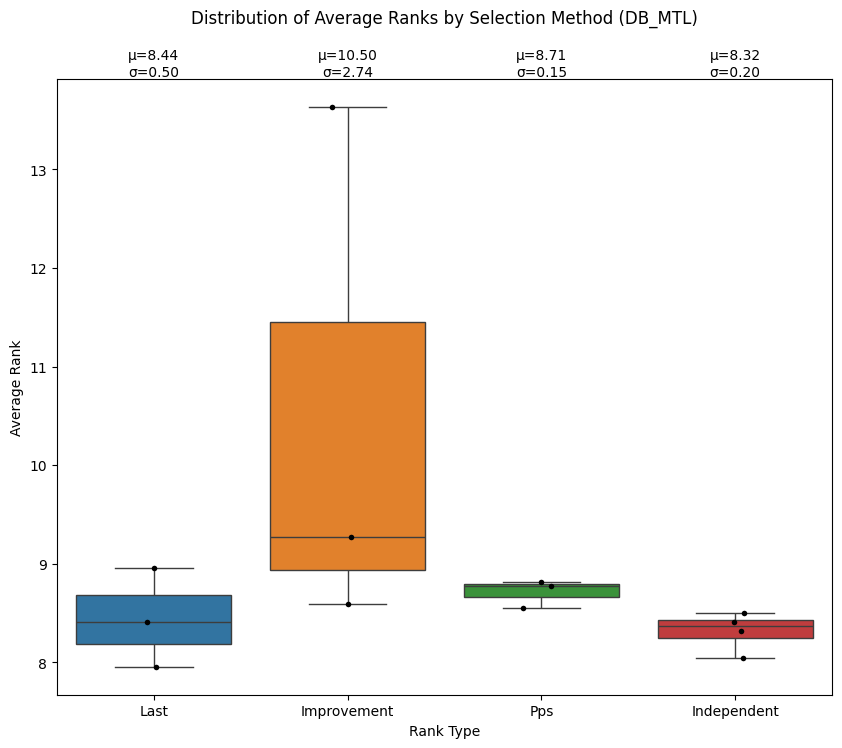

In [ ]:
api = wandb.Api()
sweep_id = "7bnrymnb"
runs = api.runs("BorgwardtLab/libmtl_tdc", filters={"sweep": sweep_id})

def update_weighting_dict(sweep_id: str, weighting_dict: dict, weighting: str, var_names: list):
    api = wandb.Api()
    runs = api.runs("BorgwardtLab/libmtl_tdc", filters={"sweep": sweep_id})

    for run in runs:
        run_weighting = run.config.get("weighting")

        if run_weighting == weighting:

            for var_name in var_names:
                var_value = run.summary.get(var_name, None)
                if var_value is None:
                    continue
            
                if weighting not in weighting_dict:
                    weighting_dict[weighting] = {}

                if var_name not in weighting_dict[weighting]:
                    weighting_dict[weighting][var_name] = []

                weighting_dict[weighting][var_name].append(var_value)

    return weighting_dict


weighting_dict = update_weighting_dict("7bnrymnb", {}, "DB_MTL", ["test/average_rank_last", "test/average_rank_improvement", "test/average_rank_pps"])
weighting_dict = update_weighting_dict("r4mrgucx", weighting_dict, "DB_MTL", ["test/average_rank_independent"])
print(weighting_dict)

plot_data = []
for weighting, vals in weighting_dict.items():
    for rank_type in ["test/average_rank_last", "test/average_rank_improvement", "test/average_rank_pps", "test/average_rank_independent"]:
        for val in vals[rank_type]:
            plot_data.append({
                "Weighting": weighting,
                "Rank Type": rank_type.split("_")[-1].capitalize(),
                "Value": val
            })

plt.figure(figsize=(10, 8))
df = pd.DataFrame(plot_data)
sns.boxplot(data=df, x='Rank Type', y='Value', hue='Rank Type')
sns.stripplot(data=df, x='Rank Type', y='Value', color='black', alpha=1.0, jitter=0.1, size=4)

for i, rank_type in enumerate(df['Rank Type'].unique()):
    vals = df[df['Rank Type'] == rank_type]['Value']
    mean = vals.mean()
    std = vals.std()
    plt.text(i, plt.ylim()[1], f'μ={mean:.2f}\nσ={std:.2f}', 
             horizontalalignment='center', verticalalignment='bottom')

plt.ylabel("Average Rank")
plt.title(f"Distribution of Average Ranks by Selection Method (DB_MTL)", pad=40)
plt.show()


In [38]:
values = ["test/average_rank_last", "test/average_rank_improvement", "test/average_rank_pps", "test/average_rank_independent"]

weighting_dict = update_weighting_dict("c1zmckcc", {}, "EW", values)
weighting_dict = update_weighting_dict("ma6eb4vg", weighting_dict, "FairGrad", values)
weighting_dict = update_weighting_dict("hl8f1m7y", weighting_dict, "DB_MTL", values)

plot_data = []
for weighting, vals in weighting_dict.items():
    for rank_type in values:
        for val in vals[rank_type]:
            plot_data.append({
                "Weighting": weighting,
                "Rank Type": rank_type.split("_")[-1].capitalize(),
                "Value": val
            })


plt.figure(figsize=(10, 8))
df = pd.DataFrame(plot_data)
# sns.boxplot(data=df, x='Weighting', y='Value', hue='Rank Type')
sns.stripplot(data=df, x='Weighting', y='Value', hue='Rank Type', alpha=1.0, jitter=0.1, size=10)
plt.title("Long runs 500 epochs")

TypeError: update_weighting_dict() missing 1 required positional argument: 'config_keys'

Text(0.5, 1.0, 'Smiles leakage methods compared')

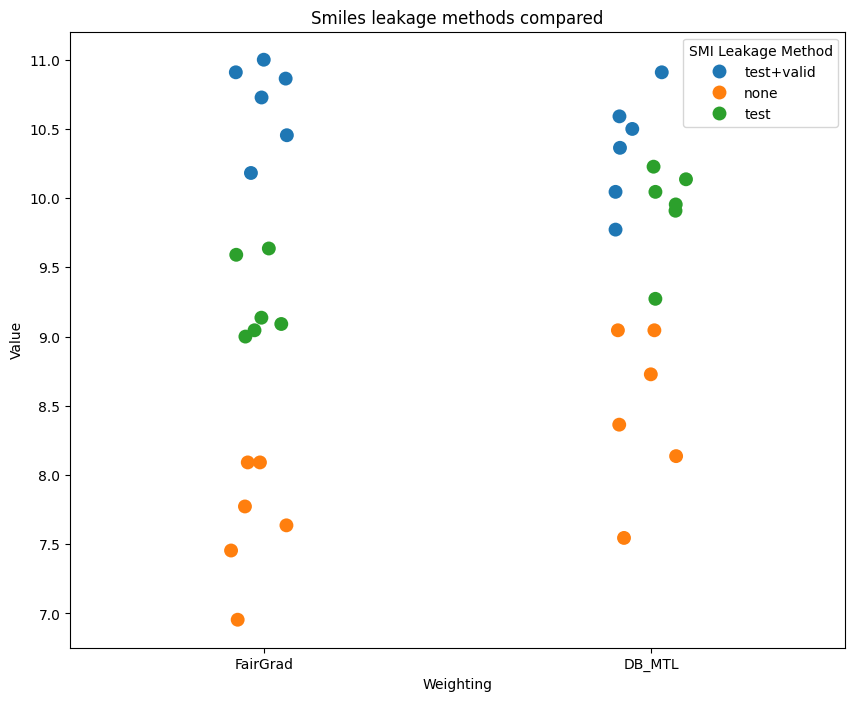

In [40]:
def update_weighting_dict(sweep_id: str, weighting_dict: dict, weighting: str, summary_keys: list):
    api = wandb.Api()
    runs = api.runs("BorgwardtLab/libmtl_tdc", filters={"sweep": sweep_id})

    for run in runs:
        run_weighting = run.config.get("weighting")
        run_smi_leakage_method = run.config.get("smi_leakage_method")

        if run_weighting == weighting:

            for var_name in summary_keys:
                var_value = run.summary.get(var_name, None)
                if var_value is None:
                    continue
            
                if (weighting, run_smi_leakage_method) not in weighting_dict:
                    weighting_dict[(weighting, run_smi_leakage_method)] = {}

                if var_name not in weighting_dict[(weighting, run_smi_leakage_method)]:
                    weighting_dict[(weighting, run_smi_leakage_method)][var_name] = []

                weighting_dict[(weighting, run_smi_leakage_method)][var_name].append(var_value)

    return weighting_dict


values = ["test/average_rank_last"]

weighting_dict = update_weighting_dict("cblj5s09", {}, "FairGrad", values)
weighting_dict = update_weighting_dict("q2c22d30", weighting_dict, "DB_MTL", values)

plot_data = []
for (weighting, smi_leakage_method), vals in weighting_dict.items():
    for rank_type in values:
        for val in vals[rank_type]:
            plot_data.append({
                "Weighting": weighting,
                "SMI Leakage Method": smi_leakage_method,
                "Value": val
            })

plt.figure(figsize=(10, 8))
df = pd.DataFrame(plot_data)
sns.stripplot(data=df, x='Weighting', y='Value', hue='SMI Leakage Method', alpha=1.0, jitter=0.1, size=10)
plt.title("Smiles leakage methods compared")